# Adoption Prediction
build the best predictive  model for the next marketing
campaign,  i.e.,  for  predicting  likely  adopters  (that  is,  which  current  non -
                                                      subscribers  are  likely  to  respond  to  the  marketing  campaign and sign  up for
                                                      the  premium  service  within  6  months  after  the  campaign).
## Model Targets
- Beat f1 score: 0.12
- NN002 f1 score: 0.111

# Import Data

In [4]:
import pandas as pd
labeledData = pd.read_csv(r'../Data/LabelData.csv')
UnlabeledData = pd.read_csv(r'../Data/UnlabelData.csv')
labeledData.head(1)


,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
0,10,24,0,20,26.333333,0.777778,6,0,37804,4,...,0,54,0,0,0,0,79,0,0,0


# NN Libraries

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import tensorflow as tf
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch



In [7]:
# setting fixed seed value for consistency in results
seed = 42
np.random.seed(seed)

In [6]:
# Load the data
X = labeledData.drop(['adopter', 'user_id'], axis=1)
y = labeledData['adopter']

# Train-test split 7:3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print ("Number of train instances: {}".format(len(X_train)))
print ("Number of test instances: {}".format(len(X_test)))

Number of train instances: 40653
Number of test instances: 17424


In [56]:
# fetching the indices of minority instances
adopting_indices = np.array(labeledData[labeledData.adopter == 1].index)

# fetching indices of normal instances
non_adopting_indices = labeledData[labeledData.adopter == 0].index

# randomly select 1540 normal instances to create a partitioned balanced dataset
# num_non_adopting_to_sample = 5040
num_non_adopting_to_sample = 6000
random_non_adopting_indices = np.random.choice(non_adopting_indices,
                                               num_non_adopting_to_sample,
                                               replace=False)
random_non_adopting_indices = np.array(random_non_adopting_indices)

# combining both the instance groups (minority and the new random set)
undersampled_indices = np.concatenate(
    [adopting_indices, random_non_adopting_indices])

# creating the undersampled dataset
undersampled_data = labeledData.iloc[undersampled_indices, :]

# shuffling the new dataset
undersampled_data = shuffle(undersampled_data)

# storing the features(X) and predictor class(y)
cols_to_exclude = ['adopter', 'user_id']
X_undersample = undersampled_data.loc[:, ~
                                      undersampled_data.columns.isin(cols_to_exclude)]
y_undersample = undersampled_data.iloc[:,
                                       undersampled_data.columns == 'adopter']

print("Number of minority instances: {}\nNumber of normal instances: {} \nTotal: {}".format(len(undersampled_data[undersampled_data.adopter == 1]),
                                                                                            len(
                                                                                                undersampled_data[undersampled_data.adopter == 0]),
                                                                                            len(undersampled_data)))


Number of minority instances: 1029
Number of normal instances: 6000 
Total: 7029


In [50]:
# splitting original dataset into features and predictor
X = undersampled_data.loc[:, ~undersampled_data.columns.isin(cols_to_exclude)]
y = undersampled_data.iloc[:, labeledData.columns == 'adopter']

# splitting the original dataset for cross-validation (0.7 train, 0.3 test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Undersampled Data:")
print("Number of train instances: {}".format(len(X_train)))
print("Number of test instances: {}".format(len(X_test)))


Undersampled Data:
Number of train instances: 4248
Number of test instances: 1821


In [30]:
sm = SMOTE(random_state = seed, sampling_strategy='auto')
X_train_smoted_np, y_train_smoted_np = sm.fit_resample(X_train, y_train)

In [33]:
# # checking the lengths of new training set

print ("Number of SMOTEd instances: {}".format(len(X_train_smoted_np)))

y_train_smoted_non_adopters = y_train_smoted_np[y_train_smoted_np == 1]
y_train_smoted_adopters = y_train_smoted_np[y_train_smoted_np == 0]

print ("Number of SMOTEd non-adopters (adopter = 0): {}".format(len(y_train_smoted_non_adopters)))
print ("Number of SMOTEd adopters (adopter = 1): {}".format(len(y_train_smoted_adopters)))


Number of SMOTEd instances: 7038
Number of SMOTEd non-adopters (adopter = 0): 7038
Number of SMOTEd adopters (adopter = 1): 7038


# Neural Network(NN) Model

In [45]:

# Create a Neural Network model
def create_model():
    Dropout_Rate = 0.5
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


# NN Random Oversampling

57/57 [==============================] - 0s 1ms/step
Run 1: F1 Score: 0.5184426229508197
57/57 [==============================] - 0s 637us/step
Run 2: F1 Score: 0.5253164556962026
57/57 [==============================] - 0s 700us/step
Run 3: F1 Score: 0.5009523809523809
57/57 [==============================] - 0s 652us/step
Run 4: F1 Score: 0.5337552742616034
57/57 [==============================] - 0s 933us/step
Run 5: F1 Score: 0.543123543123543
Average F1 Score: 0.52431805539691


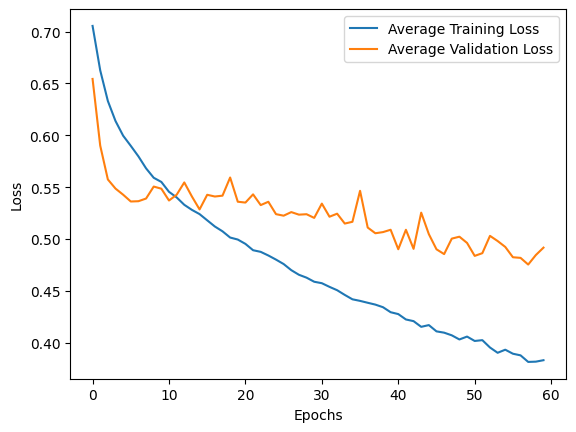

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=3, restore_best_weights=True)

f1_scores = []
training_losses = []
validation_losses = []

for i in range(5):
    # Clone the model
    model_1 = create_model()

    # Train the model
    history = model_1.fit(X_train_smoted_np, y_train_smoted_np,
                          epochs=60, batch_size=128,
                          verbose=0, callbacks=[early_stopping],
                          validation_data=(X_test, y_test))
    # Evaluate the model
    y_pred = (model_1.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Run {i+1}: F1 Score: {f1}")
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    f1_scores.append(f1)

    if f1 < 0.085:
        print("Breaking the loop due to low F1 score.")
        break

average_f1 = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1}")

# Calculate the average training and validation losses over all runs
avg_training_loss = np.mean(training_losses, axis=0)
avg_validation_loss = np.mean(validation_losses, axis=0)

# Plot the average training and validation losses
plt.plot(avg_training_loss, label='Average Training Loss')
plt.plot(avg_validation_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [38]:
# print(avg_training_loss, avg_validation_loss)
# Top record F1 Score: 0.543123543123543
# Top Avg F1 Score: 0.52431805539691
model_1.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 256)               6656      
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 32)               